In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv("../data/spot_5min_features.csv",parse_dates=["Datetime"])
df=df.set_index("Datetime").sort_index()
df=df.copy()
print(df.head())
print(df.columns)

                                 open        high         low       close  \
Datetime                                                                    
2025-11-18 05:55:00+00:00  293.299988  293.299988  293.089996  293.089996   
2025-11-18 06:00:00+00:00  293.079987  293.200012  293.000000  293.149994   
2025-11-18 06:05:00+00:00  293.200012  293.299988  293.130005  293.269989   
2025-11-18 06:10:00+00:00  293.269989  293.410004  293.230011  293.329987   
2025-11-18 06:15:00+00:00  293.429993  293.589996  293.339996  293.450012   

                             volume     ret_1     ret_5      ema_20  \
Datetime                                                              
2025-11-18 05:55:00+00:00  122093.0 -0.000784 -0.000205  293.092066   
2025-11-18 06:00:00+00:00   25759.0  0.000205  0.000171  293.097583   
2025-11-18 06:05:00+00:00   22863.0  0.000409  0.000307  293.114002   
2025-11-18 06:10:00+00:00   23578.0  0.000205  0.000341  293.134572   
2025-11-18 06:15:00+00:00   37559.

In [2]:
df = pd.read_csv("../data/spot_5min_features.csv")
print(df.columns)


Index(['Datetime', 'open', 'high', 'low', 'close', 'volume', 'ret_1', 'ret_5',
       'ema_20', 'ema_50', 'ema_diff', 'volatility_20', 'volatility_100',
       'hl_range', 'volume_z', 'sentiment_pressure', 'future_price', 'basis',
       'delta_proxy', 'gamma_proxy', 'vega_proxy', 'theta_proxy'],
      dtype='object')


In [3]:
print(df.shape)
print(df.columns)


(3047, 22)
Index(['Datetime', 'open', 'high', 'low', 'close', 'volume', 'ret_1', 'ret_5',
       'ema_20', 'ema_50', 'ema_diff', 'volatility_20', 'volatility_100',
       'hl_range', 'volume_z', 'sentiment_pressure', 'future_price', 'basis',
       'delta_proxy', 'gamma_proxy', 'vega_proxy', 'theta_proxy'],
      dtype='object')


In [4]:
hmm_features = df[
    [
        "ret_1",
        "volatility_100",
        "basis",
        "sentiment_pressure",
        "ema_diff"
    ]
].copy()

hmm_features = hmm_features.dropna()
df = df.loc[hmm_features.index].copy()


In [5]:
hmm_features=hmm_features.dropna()
df=df.loc[hmm_features.index].copy()

In [6]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(hmm_features.values)
print(X.shape)

(3047, 5)


In [7]:
split=int(0.7*len(df))
X_train=X[:split]
X_all=X

In [8]:
from hmmlearn.hmm import GaussianHMM
model=GaussianHMM(
    n_components=3,
    covariance_type="diag",
    n_iter=1000,
    random_state=42,
    init_params="kmeans"
)
model.fit(X_train)
hidden_states=model.predict(X_all)
df["regime"]=hidden_states
print(df["regime"].value_counts())

regime
2    2607
1     388
0      52
Name: count, dtype: int64


In [9]:
regime_stats = df.groupby("regime")[["ret_1", "volatility_100", "ema_diff", "sentiment_pressure", "basis"]].mean()
print(regime_stats)


           ret_1  volatility_100  ema_diff  sentiment_pressure   basis
regime                                                                
0      -0.000207        0.000577 -0.054913            0.002167  0.0001
1      -0.000027        0.000514 -0.050532            0.001493  0.0001
2       0.000005        0.000503 -0.005560           -0.000167  0.0001


In [10]:
regime_map = {
    0: "Downtrend",
    1: "Sideways",
    2: "Uptrend"
}
df["regime_name"] = df["regime"].map(regime_map)
df[["regime", "regime_name"]].head()

,regime,regime_name
0,1,Sideways
1,2,Uptrend
2,2,Uptrend
3,2,Uptrend
4,2,Uptrend


In [11]:
df["regime_name"].value_counts()


regime_name
Uptrend      2607
Sideways      388
Downtrend      52
Name: count, dtype: int64

In [12]:
df.groupby("regime_name")[["ret_1", "volatility_100"]].mean()

,ret_1,volatility_100
regime_name,,
Downtrend,-0.000207,0.000577
Sideways,-0.000027,0.000514
Uptrend,0.000005,0.000503


In [13]:
import seaborn as sns
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime").reset_index(drop=True)
import os
os.makedirs("../plots", exist_ok=True)

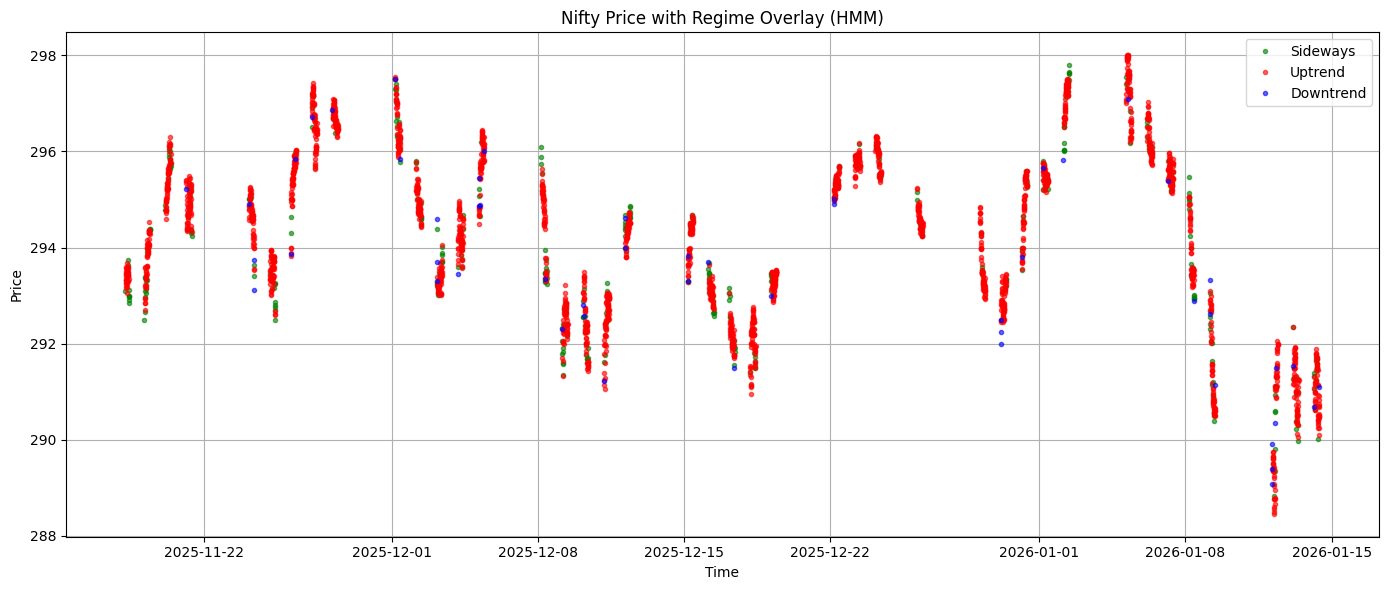

In [15]:
colors = {
    "Uptrend": "red",
    "Downtrend": "blue",
    "Sideways": "green"
}

plt.figure(figsize=(14,6))

for regime in df["regime_name"].unique():
    mask = df["regime_name"] == regime
    plt.plot(
        df.loc[mask, "Datetime"],
        df.loc[mask, "close"],
        ".",
        label=regime,
        color=colors[regime],
        alpha=0.6
    )

plt.title("Nifty Price with Regime Overlay (HMM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../plots/regime_overlay_labeled.png", dpi=200)
plt.show()


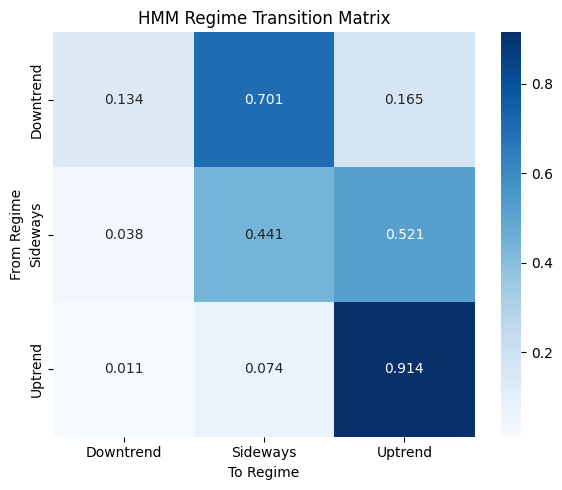

In [16]:
transmat = model.transmat_
plt.figure(figsize=(6,5))
sns.heatmap(
    transmat,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=["Downtrend", "Sideways", "Uptrend"],
    yticklabels=["Downtrend", "Sideways", "Uptrend"]
)
plt.title("HMM Regime Transition Matrix")
plt.xlabel("To Regime")
plt.ylabel("From Regime")

plt.tight_layout()
plt.savefig("../plots/transition_matrix.png", dpi=200)
plt.show()

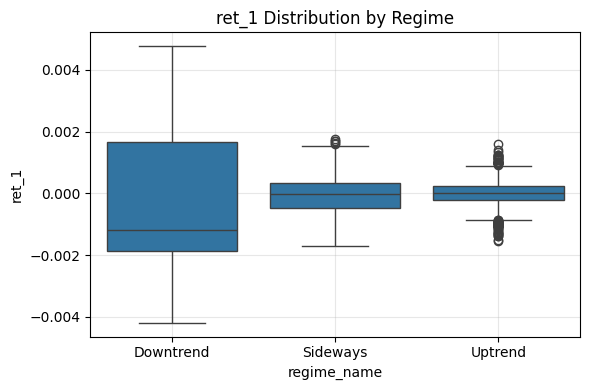

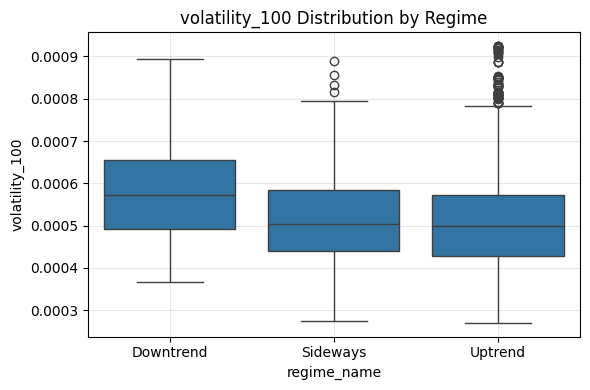

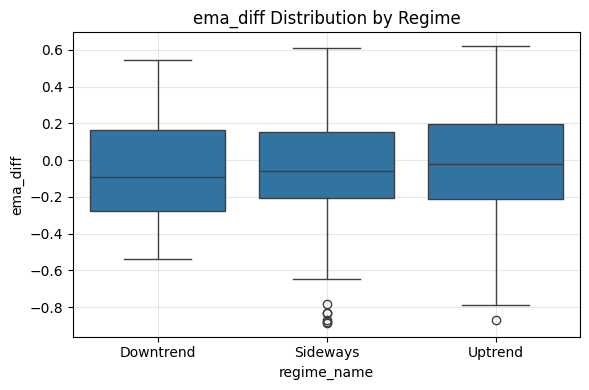

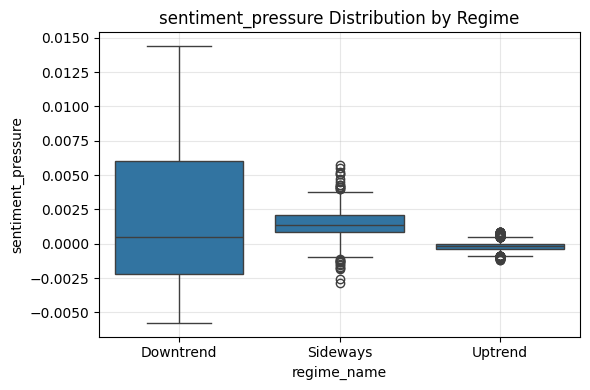

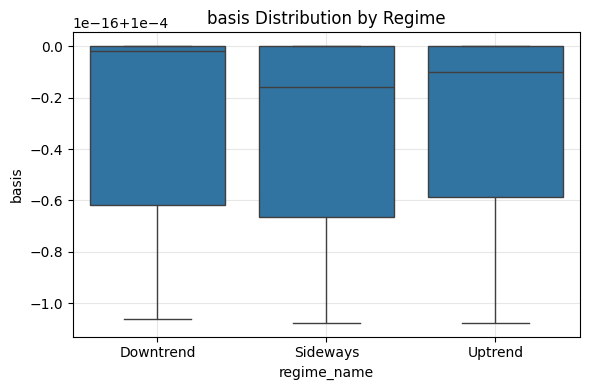

In [17]:
features_to_plot = [
    "ret_1",
    "volatility_100",
    "ema_diff",
    "sentiment_pressure",
    "basis"
]
for feat in features_to_plot:
    plt.figure(figsize=(6,4))
    
    sns.boxplot(
        x="regime_name",
        y=feat,
        data=df,
        order=["Downtrend", "Sideways", "Uptrend"]
    )
    plt.title(f"{feat} Distribution by Regime")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"../plots/regime_stats_{feat}.png", dpi=200)
    plt.show()

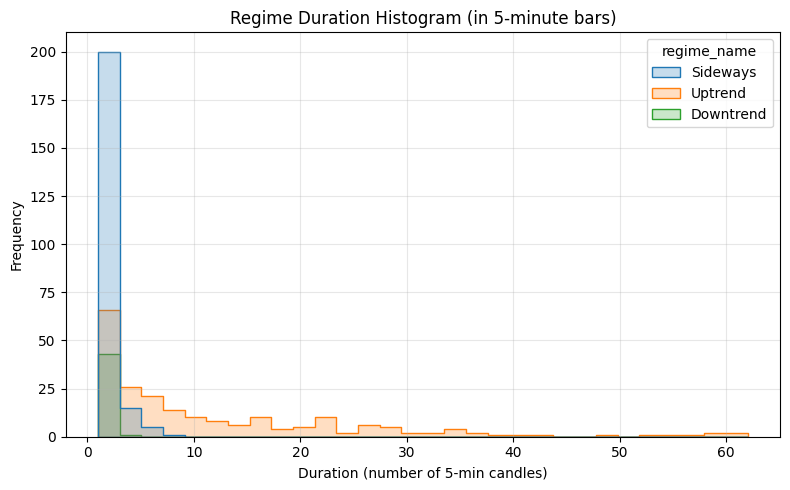

In [18]:
regimes = df["regime_name"].values
durations = []
current_regime = regimes[0]
count = 1
for i in range(1, len(regimes)):
    if regimes[i] == current_regime:
        count += 1
    else:
        durations.append((current_regime, count))
        current_regime = regimes[i]
        count = 1
durations.append((current_regime, count))
dur_df = pd.DataFrame(durations, columns=["regime_name", "duration_bars"])
plt.figure(figsize=(8,5))
sns.histplot(
    data=dur_df,
    x="duration_bars",
    hue="regime_name",
    bins=30,
    kde=False,
    element="step"
)
plt.title("Regime Duration Histogram (in 5-minute bars)")
plt.xlabel("Duration (number of 5-min candles)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/regime_duration_hist.png", dpi=200)
plt.show()

In [20]:
df_to_save = df.reset_index()
df_to_save.to_csv("../data/spot_5min_features_with_regime.csv", index=False)
print("Saved spot_5min_features_with_regime.csv with Datetime column.")


Saved spot_5min_features_with_regime.csv with Datetime column.


In [21]:
import joblib
import os
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/hmm_regime_model.pkl")
print("HMM model saved to models/hmm_regime_model.pkl")

HMM model saved to models/hmm_regime_model.pkl
